In [10]:
import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
from collections import OrderedDict

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def get_config():
    return {
        'batch_size': 128,
        'learning_rate': 1e-3,
        'n_epoch': 10,
        'hidden_sizes': [512,128,32],
    }

config = get_config()

In [4]:
# Load MNIST dataset from torchvision
import torchvision
from torchvision import transforms

train_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train = True,
                                           transform=transforms.ToTensor(),
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='../../data',
                                          train = False,
                                          transform=transforms.ToTensor())


In [5]:
train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset,
                                               batch_size = config['batch_size'],
                                               shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset,
                                               batch_size = config['batch_size'],
                                               shuffle=False)
train_size = len(train_dataloader.dataset)
test_size = len(test_dataloader.dataset)

In [6]:
examples = iter(train_dataloader)
sample_data, sample_label = next(examples) # one batch train data
print(sample_data.size(), sample_label.size())

torch.Size([128, 1, 28, 28]) torch.Size([128])


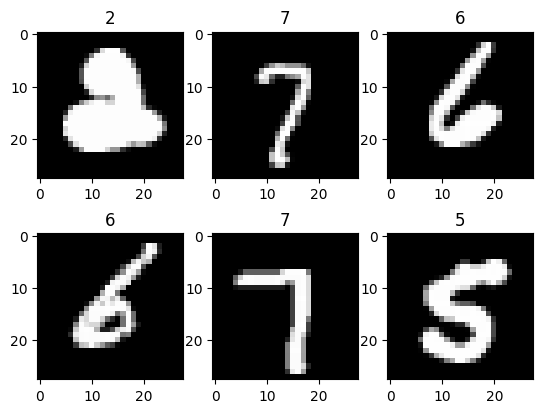

In [7]:
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.title(sample_label[i].numpy())
    plt.imshow(sample_data[i][0], cmap='gray')

In [15]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super().__init__()
        self.input_size = input_size
        self.layer_dims = [input_size] + hidden_layers + [output_size]
        self.output_size = output_size
        self.model = None
        
    def build(self):
        self.layers = OrderedDict()
        for i in range(1, len(self.layer_dims)):
            self.layers[f'linear{i}'] = nn.Linear(self.layer_dims[i-1], self.layer_dims[i])
            if i < len(self.layer_dims) - 1:
                self.layers[f'relu{i}'] = nn.ReLU()
        self.model = nn.Sequential(self.layers)
        # print(self.model)
        
    def forward(self, x):
        if not self.model:
            self.build()
        return self.model(x)
        

In [16]:
dnn = DNN(784, [512, 128, 32], 10)
dnn.build()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn.parameters(), lr = config['learning_rate'])

In [14]:
for epoch in range(config['n_epoch']):
    print(f'--------------Epoch {epoch+1}---------------')
    train_epoch_loss = []
    train_epoch_acc = []
    for i_batch, batch in enumerate(train_dataloader):
        y_true = batch[1]
        y_logits = dnn(batch[0].reshape(batch[0].shape[0],-1))
        y_pred = torch.argmax(y_logits,-1)
        
        loss = loss_fn(y_logits, y_true)
        train_epoch_loss.append(loss.detach().numpy())
        train_epoch_acc.append((y_pred==y_true).numpy().mean())
        if i_batch % 100 == 0:  # print loss every 100 batches
            print(f'Batch train loss: {loss:.5f}, [{(i_batch+1) * batch[0].shape[0]}/{train_size} examples]') 
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    test_epoch_loss = []
    test_epoch_acc = []
    for i_batch, batch in enumerate(test_dataloader):
        y_true = batch[1]
        y_logits = dnn(batch[0].reshape(batch[0].shape[0],-1))
        y_pred = torch.argmax(y_logits,-1)
        test_epoch_loss.append(loss_fn(y_logits, y_true).detach().numpy())
        test_epoch_acc.append((y_pred==y_true).numpy().mean())
    print(f'Epoch train loss: {np.array(train_epoch_loss).mean():.5f}, Epoch train acc: {np.array(train_epoch_acc).mean():.5f}')
    print(f'Epoch test loss: {np.array(test_epoch_loss).mean():.5f}, Epoch test acc: {np.array(test_epoch_acc).mean():.5f}')

--------------Epoch 1---------------
Batch train loss: 2.30098, [128/60000 examples]
Batch train loss: 0.38886, [12928/60000 examples]
Batch train loss: 0.21374, [25728/60000 examples]
Batch train loss: 0.14954, [38528/60000 examples]
Batch train loss: 0.22081, [51328/60000 examples]
Epoch train loss: 0.36170, Epoch train acc: 0.89558
Epoch test loss: 0.15817, Epoch test acc: 0.95085
--------------Epoch 2---------------
Batch train loss: 0.18203, [128/60000 examples]
Batch train loss: 0.06267, [12928/60000 examples]
Batch train loss: 0.09264, [25728/60000 examples]
Batch train loss: 0.05252, [38528/60000 examples]
Batch train loss: 0.09683, [51328/60000 examples]
Epoch train loss: 0.12847, Epoch train acc: 0.96142
Epoch test loss: 0.10762, Epoch test acc: 0.96766
--------------Epoch 3---------------
Batch train loss: 0.04903, [128/60000 examples]
Batch train loss: 0.07768, [12928/60000 examples]
Batch train loss: 0.07194, [25728/60000 examples]
Batch train loss: 0.03437, [38528/60000 e